# Notes
This is the notebook for training and running the Default model:
 - A single image is passed into the YOLOv8 backbone, resulting in a feature vector
 - The feature vector is then sent directly to a classification head, which then predicts good/bad.

I have all of the models get training data from a directory structure. This design decision was influenced by YOLO itself - before I used the classification variant I was labeling the training data in label studio and making bounding boxes, and I had to use this directory structure. It is now no critical to the design of the model, but it works well.

## SET MODEL SETTINGS

In [1]:
# Set to either 'grind_trial' or 'polish_trial'
train_type = 'polish_trial'
# The trial number (1-5)
trial_num = 5

# Set the training data pickle file name string
data_batch_file_str = f'train_batch_{train_type}_df.pkl'

# Set the custom identifier for the output model metrics files
# Choose a unique one.
variant_name = f'{trial_num}{train_type}'

# Number of epochs for training
epochs = 100
# Learning rate
max_lr = 0.0001

# Sometimes it's useful to run this notebook without training
start_training = False

# Batch size and number of workers:
batch_size = 16
num_workers = 4
# Jitter params
jitter_params = dict(brightness=0.1, contrast=0.1, saturation=0, hue=0)

## Obtain Project Directory

In [2]:
from pathlib import Path
notebook_dir = Path.cwd()
parent_dir = notebook_dir.parent.parent
print(parent_dir)

c:\Users\jackson129\OneDrive - LLNL\APEX_Cornell_Analysis


## * Important! * - Check Model Seed

In [3]:
# Print Model Seed. It should match what is in seed_main.
# If it does not, restart this notebook to refresh __pycache__
from seed import SEED
print(SEED)

2003


# Load Pickle of Training Data

In [4]:
import pickle

with open(parent_dir / 'orchestrator' / data_batch_file_str, 'rb') as f:
    df = pickle.load(f)

display(df)

,image_id,label,grit_time,grit_step,image
0,420,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
9,421,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
18,422,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
27,423,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
36,424,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
...,...,...,...,...,...
152,772,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...
161,773,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...
170,774,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...
179,775,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...


## Create the Training & Validation Directory Structure

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from seed import SEED
import shutil
import torch
import numpy as np
import torch
import random

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Split into train/val
train_df, val_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=SEED
)

unique_grit_steps = sorted(df['grit_step'].unique())
print(f"Unique grit steps: {unique_grit_steps}")

# Define folders
base = 'dataset'

# Clear the train and validation directories
def clear_folder(folder_path):
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

# Save image
def save_subset_cls(df, subset):
    for _, row in df.iterrows():
        img_id = row['image_id']
        image  = row['image']
        cls    = row['label']

        # Create class subfolder
        class_folder = os.path.join(base, subset, str(cls))
        os.makedirs(class_folder, exist_ok=True)

        # Save image
        img_path = os.path.join(class_folder, f"{img_id}.jpg")
        image.save(img_path, format='JPEG', quality=95)


clear_folder('dataset')
# Save images in the new structure
save_subset_cls(train_df, 'train')
save_subset_cls(val_df, 'val')

# Save train and val metadata
train_metadata = train_df[['image_id', 'grit_time', 'grit_step', 'label']].copy()
train_metadata.to_csv(os.path.join(base, 'train_metadata.csv'), index=False)

val_metadata = val_df[['image_id', 'grit_time', 'grit_step', 'label']].copy()
val_metadata.to_csv(os.path.join(base, 'val_metadata.csv'), index=False)

# Optionally, I save metadata if you still need it for analysis
md = df[['image_id','grit_time','grit_step','label']].copy()
md.to_csv(os.path.join(base, 'metadata.csv'), index=False)

Unique grit steps: [np.float64(0.08), np.float64(0.3), np.float64(1.0)]


## Create Data Loaders and Add Augmentations

Train samples: 528
  Val samples: 57
Sample shapes:
  image: torch.Size([3, 640, 640])
  meta:  torch.Size([2])
  label: tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.443468..0.9925628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.483892..0.8106553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4030442..1.3765898].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2211366..1.3765898].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5041041..1.3765898].


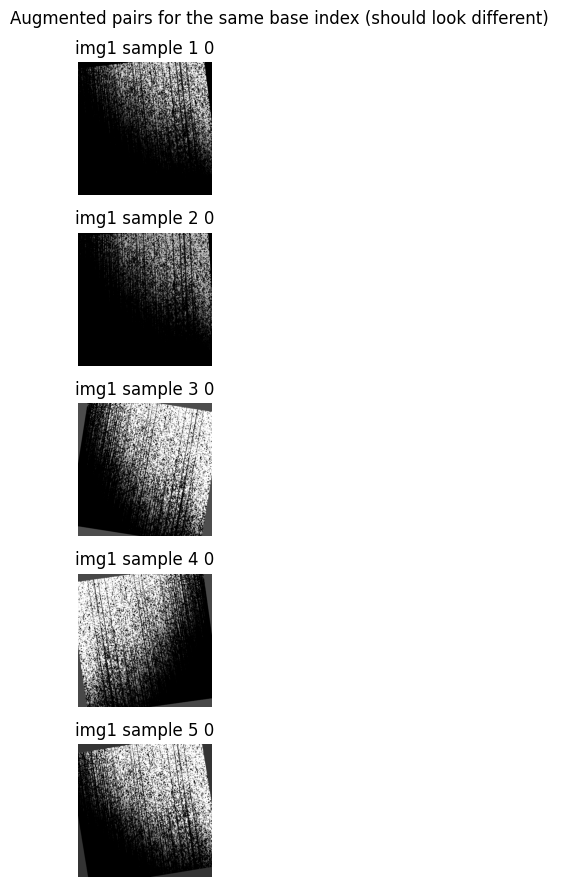

In [6]:
import torch
from torch.utils.data import DataLoader
from dataset import*

# Ensure deterministic transformations
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)

# Define transforms
train_transform = SingleImageTransform(
    image_size=(640, 640),
    train=True,
    flip_prob=0.5,
    rotation_degrees=10,
    jitter_params=jitter_params
)
val_transform = SingleImageTransform(
    image_size=(640, 640),
    train=False
)

# Metadata columns
meta_cols = ['grit_time', 'grit_step']
train_meta_df = pd.read_csv("dataset/train_metadata.csv")

# These are used for both the train and validation datasets
meta_mean = train_meta_df[meta_cols].mean().values
meta_std  = train_meta_df[meta_cols].std().values

# Train and validation datasets
train_ds = GrindingDataset(
    images_dir="dataset/train",
    metadata_csv="dataset/train_metadata.csv",
    filename_col="image_id",
    metadata_cols=meta_cols,
    transform=train_transform,
    aug_factor=4,
    meta_mean=meta_mean,
    meta_std=meta_std
)
val_ds = GrindingDataset(
    images_dir="dataset/val",
    metadata_csv="dataset/val_metadata.csv",
    filename_col="image_id",
    metadata_cols=meta_cols,
    transform=val_transform,
    meta_mean=meta_mean,
    meta_std=meta_std
)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Train samples: {len(train_ds)}")
print(f"  Val samples: {len(val_ds)}")

# INSPECT A SAMPLE:
img, meta, lbl = train_ds[0]
print("Sample shapes:")
print("  image:", img.size())
print("  meta: ", meta.size())
print("  label:", lbl)



import matplotlib.pyplot as plt
import numpy as np

# Your normalization parameters
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def unnormalize(img_tensor):
    # img_tensor: (3, H, W), torch.Tensor
    img = img_tensor.clone().detach().cpu().numpy()
    img = img.transpose(1, 2, 0)  # (H, W, 3)
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

# Pick a base index (e.g., 0)
base_idx = 0
n_samples = 5

fig, axes = plt.subplots(n_samples, 2, figsize=(6, 9))
fig.suptitle("Augmented pairs for the same base index (should look different)")

for i in range(n_samples):
    idx = base_idx + i * len(train_ds.df)
    img1, meta1, label = train_ds[idx]
    # Normalized image for left
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    axes[i, 0].imshow(img1_np)
    axes[i, 0].set_title(f"img1 sample {i+1} {label}")

    for ax in axes[i]:
        ax.axis('off')

plt.tight_layout()
plt.show()

## Train YOLO

In [7]:
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR
import time
from model import*
from yolo_backbone import*

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Instantiate backbone and classifier
backbone = YOLOv8Backbone(weights='yolov8n-cls.pt').to(device)
with torch.no_grad():
    dummy = torch.randn(1, 3, 640, 640).to(device)
    num_features = backbone(dummy).shape[1]

model = BinaryClassifier(backbone, num_features).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-2)

steps_per_epoch = len(train_loader)
"""scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)
"""

all_val_labels = []
all_val_preds = []
all_val_probs = []

training_start_time = time.time()

if start_training:
    epoch_metrics = []
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        # TRAINING LOOP WITH PROGRESS BAR
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)
        for images, _, labels in train_loader_tqdm:
            images = images.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #scheduler.step()  # <-- Add this line

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Optionally, update tqdm bar postfix with metrics
            train_loader_tqdm.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = correct / total

        # VALIDATION LOOP WITH PROGRESS BAR
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0


        # ... inside your epoch loop
        all_labels = []
        all_preds = []
        all_probs = []

        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False)
            for images, _, labels in val_loader_tqdm:
                images = images.to(device)
                labels = labels.to(device).long()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                # Get probabilities for class 1 (positive class)
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                preds = np.argmax(outputs.cpu().numpy(), axis=1)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds)
                all_probs.extend(probs)

                val_correct += (preds == labels.cpu().numpy()).sum()
                val_total += labels.size(0)
                val_loader_tqdm.set_postfix(loss=loss.item())

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Convert lists to numpy arrays
        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        all_probs = np.array(all_probs)

        # Accumulate across all epochs
        all_val_labels.extend(all_labels.tolist())
        all_val_preds.extend(all_preds.tolist())
        all_val_probs.extend(all_probs.tolist())

        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        try:
            roc_auc = roc_auc_score(all_labels, all_probs)
        except ValueError:
            roc_auc = float('nan')  # If only one class present in y_true

        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC AUC: {roc_auc:.4f}")

        print(f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        elapsed_time = time.time() - training_start_time

        epoch_metrics.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "val_true_labels": all_labels,  # Only this epoch
            "val_pred_labels": all_preds,
            "val_probs": all_probs,
            "time": elapsed_time,
        })

    # --- Save all epoch metrics to pickle ---
    with open(f"runs/run{variant_name}.pkl", "wb") as f:
        pickle.dump(epoch_metrics, f)
    print(f"Saved all epoch metrics to out{variant_name}.pkl")

    torch.save(model.state_dict(), f'saved_models/model_{variant_name}.pth')


Setup: Will run dynamic‐forward on modules [0:9]  Setup(Detect is at 9)


## Measure Inference Time

In [8]:
import torch
import time
import numpy as np
import pickle

def measure_single_sample_inference_time(
    model, 
    sample, 
    device=None, 
    num_repeats=100, 
    input_unpack_fn=None
):
    """
    Measures inference time statistics for a single sample repeated num_repeats times.
    Args:
        model: PyTorch model (should be in eval mode)
        sample: A single batch/sample from the dataloader
        device: torch.device or None (default: use model's device)
        num_repeats: Number of times to repeat inference (default: 100)
        input_unpack_fn: Optional function to extract model inputs from sample
    Returns:
        total_time, avg_time_per_sample, std_dev, std_error
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    if input_unpack_fn is None:
        input_unpack_fn = lambda batch: batch[0] if isinstance(batch, (tuple, list)) else batch

    # Move sample to device
    if isinstance(sample, (tuple, list)):
        sample_on_device = [b.to(device) if torch.is_tensor(b) else b for b in sample]
    elif isinstance(sample, dict):
        sample_on_device = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in sample.items()}
    else:
        sample_on_device = sample.to(device) if torch.is_tensor(sample) else sample

    model_inputs = input_unpack_fn(sample_on_device)
    if not isinstance(model_inputs, (tuple, list)):
        model_inputs = (model_inputs,)

    # List to store individual inference times
    inference_times = []

    with torch.no_grad():
        # Warmup (especially important for GPU timing)
        for _ in range(5):
            _ = model(*model_inputs)
        if device.type == "cuda":
            torch.cuda.synchronize()

        # Measure each individual inference for statistics
        for _ in range(num_repeats):
            if device.type == "cuda":
                torch.cuda.synchronize()
                
            start_time = time.time()
            _ = model(*model_inputs)
            
            if device.type == "cuda":
                torch.cuda.synchronize()
                
            end_time = time.time()
            inference_times.append(end_time - start_time)

    # Calculate statistics
    inference_times = np.array(inference_times)
    total_time = np.sum(inference_times)
    avg_time_per_sample = np.mean(inference_times)
    std_dev = np.std(inference_times, ddof=1) # trying to measure sample from LARGER distribution
    std_error = std_dev / np.sqrt(num_repeats)

    print(f"Total inference time for {num_repeats} samples: {total_time:.6f} seconds")
    print(f"Average inference time per sample: {avg_time_per_sample:.8f} seconds")
    print(f"Standard deviation: {std_dev:.8f} seconds")
    print(f"Standard error: {std_error:.8f} seconds")
    
    return total_time, avg_time_per_sample, std_dev, std_error

## Example: measure inference time for your model and val_loader
def input_unpack(batch):
    # batch = (imgs, metas, labels)
    imgs, _, _ = batch
    return imgs


model = BinaryClassifier(backbone, num_features).to(device)

sample = next(iter(val_loader))

model.load_state_dict(torch.load(f'saved_models/model_{variant_name}.pth'))
total, avg, std_dev, std_error = measure_single_sample_inference_time(
    model,
    sample,
    device=device,
    num_repeats=100,
    input_unpack_fn=input_unpack
)

# Save all the statistics
with open(f"other_metrics/inf_times_{variant_name}.pkl", "wb") as f:
    pickle.dump({
        'total': total, 
        'avg': avg, 
        'std_dev': std_dev, 
        'std_error': std_error
    }, f)

Total inference time for 100 samples: 1.050013 seconds
Average inference time per sample: 0.01050013 seconds
Standard deviation: 0.00358894 seconds
Standard error: 0.00035889 seconds


## Metrics vs. Grit

In [9]:
import torch
import pandas as pd
from collections import defaultdict
import numpy as np
from model import*
from yolo_backbone import*

backbone = YOLOv8Backbone(weights='yolov8n-cls.pt').to(device)
model = BinaryClassifier(backbone, num_features).to(device)
model.eval()

# Dict to store predictions by grit step
grit_results = defaultdict(lambda: {'correct': 0, 'total': 0})

# Run inference on validation dataset
with torch.no_grad():
    for batch in val_loader:
        imgs, metas, labels = [x.to(device) if torch.is_tensor(x) else x for x in batch]
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        
        # Get the grit steps for this batch
        # The grit_step is the second column in metas (index 1)
        normalized_grit_steps = metas[:, 1].cpu().numpy()
        grit_steps = normalized_grit_steps * meta_std[1] + meta_mean[1]
        
        # Update counts for each grit step
        for grit_step, pred, label in zip(grit_steps, preds, labels):
            # Use the exact float value without any modification
            # Snap to nearest known grit step
            closest_grit_step = min(unique_grit_steps, key=lambda x: abs(x - grit_step))
            grit_results[closest_grit_step]['total'] += 1
            if pred == label:
                grit_results[closest_grit_step]['correct'] += 1

# Convert to pandas DataFrame for easier analysis
results_data = []
for grit_step, counts in grit_results.items():
    accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else 0
    results_data.append({
        'grit_step': grit_step,
        'accuracy': accuracy,
        'count': counts['total'],
        'correct': counts['correct']
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('grit_step')

# Display results
print("Model Accuracy per Grit Step:")
print(results_df)

# Calculate overall accuracy
total_correct = sum(counts['correct'] for counts in grit_results.values())
total_samples = sum(counts['total'] for counts in grit_results.values())
overall_accuracy = total_correct / total_samples if total_samples > 0 else 0
print(f"\nOverall accuracy: {overall_accuracy:.4f}")

# Save results to pickle file
results_df.to_pickle(f'other_metrics/grit_accuracy_{variant_name}.pkl')

Setup: Will run dynamic‐forward on modules [0:9]  Setup(Detect is at 9)
Model Accuracy per Grit Step:
   grit_step  accuracy  count  correct
0       0.08  0.600000     10        6
1       0.30  0.250000     16        4
2       1.00  0.741935     31       23

Overall accuracy: 0.5789
